# Let's play with some of this NiceRide Data
We have a month's worth of data from NiceRide, specifically, data from August 2019. We'll do a bit of __exploratory data analysis__.
## EDA!!

In [1]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

import json # library to handle JSON files

# import the data set
df = pd.read_csv('/Users/no50free/GitHub/NiceRide/201908-niceride-tripdata.csv')

# import geographic data
with open('Minneapolis_Neighborhoods.geojson.json') as jsondata:
    mpls_data = json.load(jsondata)
    
nbhds = mpls_data['features']

mpls_geo = gpd.read_file('Minneapolis_Neighborhoods.geojson.json', crs={'init':'epsg:4326'})
mpls_geo = mpls_geo[['geometry', 'BDNAME']]

mpls_geo.to_crs(epsg=3596,inplace=True) # Use projected coordinate system to compute distances.

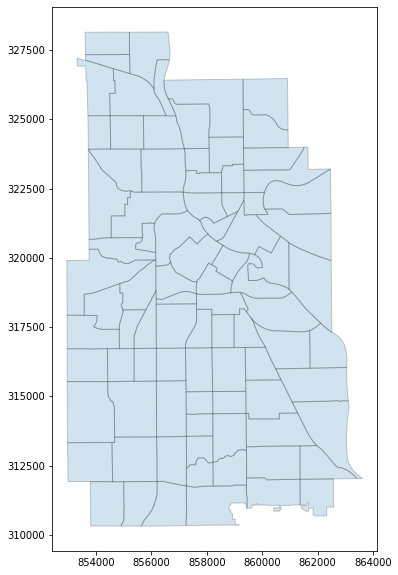

In [2]:
# To plot neighborhoods
ax = mpls_geo.plot(figsize=(20,10), edgecolor='k', alpha=0.2)

In [3]:
# The size of the data set
df.shape

(72641, 16)

We see there are 72641 instances and 16 columns. The next cell will reveal the columns.

In [4]:
# Let's see the column headers
df.columns

Index(['tripduration', 'start_time', 'end_time', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'bike type'],
      dtype='object')

As a quick first example, let's look at the birth year of our August 2019 riders. We'll use the value_counts method to count the number of instances in the column 'birth year'.

In [5]:
df['birth year'].value_counts()

1969    18883
1989     2861
1990     2643
1991     2343
1988     2320
        ...  
1944       22
1942       21
1931       13
1943        4
1901        2
Name: birth year, Length: 65, dtype: int64

### Wow!
That's a lot of people born in 1969! Let's look at a histogram.

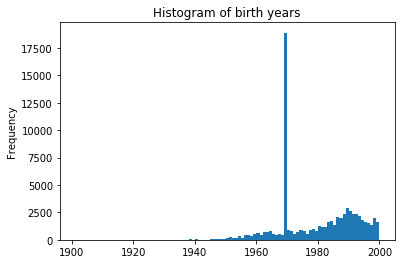

In [6]:
yearbins =range(df['birth year'].min(),df['birth year'].max())
ax = df['birth year'].plot.hist(bins=yearbins)
plt.title('Histogram of birth years')
plt.savefig('birth_years.png')

In [8]:
plt.savefig('images/birth_years.png')

<Figure size 432x288 with 0 Axes>

We now look at a trip duration histogram.

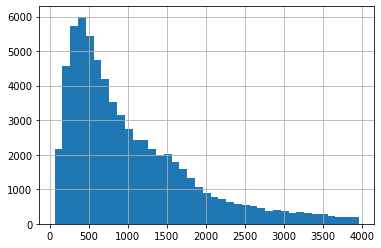

In [9]:
df['tripduration'].hist(bins=np.array(range(60,4000,100)))

We see from the above plot that the mode for `tripduration` falls in the 300-500 second range, or 50 - 80ish minutes. So an hour give or take a bit.

In [8]:
df['tripduration'].describe()

count    7.264100e+04
mean     5.995383e+03
std      7.581782e+04
min      6.100000e+01
25%      4.550000e+02
50%      8.600000e+02
75%      1.629000e+03
max      3.870305e+06
Name: tripduration, dtype: float64

In [11]:
print('median trip length is', df.tripduration.median())
print('mean trip length is', df.tripduration.mean())

median trip length is 860.0
mean trip length is 5995.38318580416


We see a large discrepancy between the mean and median trip lengths. This is likely due to significant outliers in the duration data. The median trip length is .23 hours, or about 14 minutes, and is probably a better barometer for a 'typical' ride length.

(0, 5000)

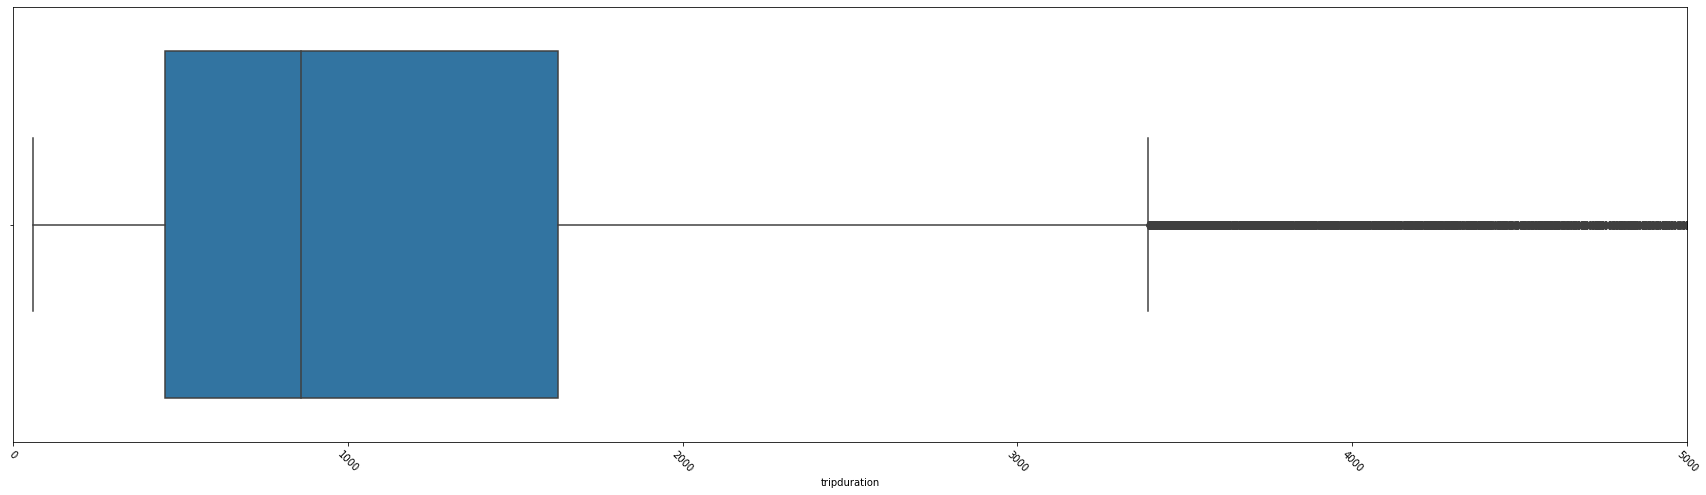

In [9]:
plt.figure(figsize=(30,8))
sns.boxplot(x='tripduration', data=df)
plt.xticks(rotation=-45)
plt.xlim(0,5000)

In [14]:
df['start station name'].value_counts()

Lake Street & Knox Ave S         1893
S 5th Street & Nicollet Mall     1236
6th Ave SE & University Ave      1192
YWCA Downtown                    1027
100 Main Street SE               1009
                                 ... 
Girard Ave N & W Broadway Ave      21
Elwood Ave N & Oak Park Ave N      10
North Commons Park                  8
Hall Park                           5
NRM Bike Shop 1                     2
Name: start station name, Length: 169, dtype: int64

In [15]:
df['end station name'].value_counts()

Lake Street & Knox Ave S         2010
S 5th Street & Nicollet Mall     1275
6th Ave SE & University Ave      1204
100 Main Street SE               1063
11th Ave S & S 2nd Street         956
                                 ... 
Willard Park                       20
North Commons Park                 18
Girard Ave N & W Broadway Ave      17
Elwood Ave N & Oak Park Ave N      10
Hall Park                           9
Name: end station name, Length: 169, dtype: int64

## Reformating trip duration
The trip duration column is measured in seconds. Let's change that to be measured in hours.

In [10]:
df['tripduration_hrs'] = df['tripduration']/(60*60)

Text(0.5, 0, 'trip hours')

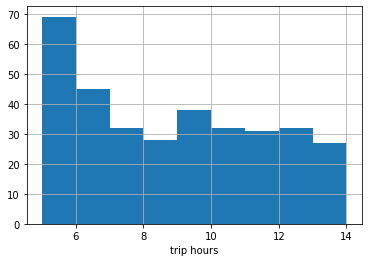

In [11]:
# histogram of long trips.
df['tripduration_hrs'].hist(bins=np.array(range(5,15,1)))
plt.xlabel('trip hours')

Looks like looking at trips under 6 hours looks like a reasonable cutoff.

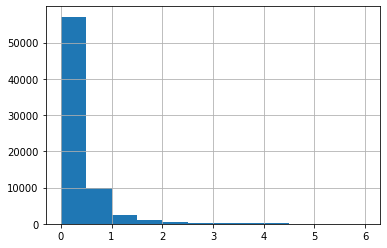

In [12]:
df['tripduration_hrs'].hist(bins=np.linspace(0,6,13))

In [13]:
sum(df['tripduration_hrs']>=6)/len(df)*100

1.2830219848295041

In [126]:
sum(df['tripduration_hrs']>=6)

932

If we trim off trips longer than 6 hours, we lose 1.2% of our dataset.

# Long trips
Let's look at these values where the trip duration is exceedingly long. We'll restrict to situations where the trip duration is over 24 hours. This may indicate the bike was lost and recovered later, or some other situation.

In [14]:
# We'll isolate the instances where 'tripduration' is longer than a day (24*60*60). Then we count the usertypes
# who fall in this range.
df_longtrips=df.loc[df['tripduration_hrs']>24 , ['usertype']]
df_longtrips['usertype'].value_counts()

Customer      407
Subscriber     52
Name: usertype, dtype: int64

It appears that about 8 times as many customers as subscribers held a bike for longer than a day.

## Convert start and end times to datetime datatype

In [15]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

## Add days of weeks
0 = Monday,
1 = Tuesday,
2 = Wednesday,
3 = Thursday,
4 = Friday,
5 = Saturday,
6 = Sunday

In [16]:
df['startdayofweek'] = df['start_time'].dt.dayofweek
df['enddayofweek'] = df['end_time'].dt.dayofweek
df.head(3)

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek
0,811,2019-08-01 00:00:44.883,2019-08-01 00:14:16.214,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,-93.255799,262,Subscriber,1991,2,Classic,0.225278,3,3
1,99,2019-08-01 00:00:48.109,2019-08-01 00:02:27.517,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,-93.276435,477,Subscriber,1990,2,Classic,0.027500,3,3
2,1205,2019-08-01 00:02:34.295,2019-08-01 00:22:39.702,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,24,Customer,1994,1,Classic,0.334722,3,3


In [17]:
# Adding names to the start

dictday={0 : 'Monday', 1 : 'Tuesday',2 : 'Wednesday', 3 : 'Thursday',4 : 'Friday', 5 : 'Saturday', 6 : 'Sunday'}
for j in range(0,len(df)):
    df.loc[j,'startday'] = dictday[df.loc[j,'startdayofweek']]

#df.rename(columns={'dayofweek':'startdayofweek'},inplace=True)
df.head()

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek,startday
0,811,2019-08-01 00:00:44.883,2019-08-01 00:14:16.214,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,-93.255799,262,Subscriber,1991,2,Classic,0.225278,3,3,Thursday
1,99,2019-08-01 00:00:48.109,2019-08-01 00:02:27.517,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,-93.276435,477,Subscriber,1990,2,Classic,0.027500,3,3,Thursday
2,1205,2019-08-01 00:02:34.295,2019-08-01 00:22:39.702,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,24,Customer,1994,1,Classic,0.334722,3,3,Thursday
3,890,2019-08-01 00:02:40.754,2019-08-01 00:17:31.156,8.0,YWCA Downtown,44.972217,-93.276435,67.0,Glenwood Ave & N Morgan Ave,44.981147,-93.304427,181,Subscriber,1990,2,Classic,0.247222,3,3,Thursday
4,1179,2019-08-01 00:03:19.343,2019-08-01 00:22:59.162,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,1310,Customer,1969,0,Classic,0.327500,3,3,Thursday


In [18]:
for j in range(0,len(df)):
    df.loc[j,'endday'] = dictday[df.loc[j,'enddayofweek']]
    
df.head(3)

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek,startday,endday
0,811,2019-08-01 00:00:44.883,2019-08-01 00:14:16.214,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,...,262,Subscriber,1991,2,Classic,0.225278,3,3,Thursday,Thursday
1,99,2019-08-01 00:00:48.109,2019-08-01 00:02:27.517,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,...,477,Subscriber,1990,2,Classic,0.027500,3,3,Thursday,Thursday
2,1205,2019-08-01 00:02:34.295,2019-08-01 00:22:39.702,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,...,24,Customer,1994,1,Classic,0.334722,3,3,Thursday,Thursday


KeyboardInterrupt: 

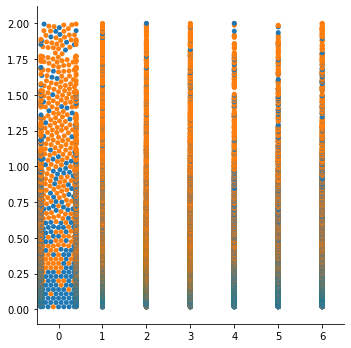

In [26]:
sns.catplot(x='startday', y='tripduration_hrs', hue='usertype', data=df[df['tripduration_hrs']<2], kind='swarm')
plt.ylim(0,3)
plt.xticks(rotation=-45)

0        0.225278
1        0.027500
2        0.334722
3        0.247222
4        0.327500
           ...   
72636    0.107222
72637    0.206944
72638    0.534167
72639    0.133333
72640    0.120833
Name: tripduration_hrs, Length: 72641, dtype: float64

In [128]:
df['end station name'].value_counts()

Lake Street & Knox Ave S         2010
S 5th Street & Nicollet Mall     1275
6th Ave SE & University Ave      1204
100 Main Street SE               1063
11th Ave S & S 2nd Street         956
                                 ... 
Willard Park                       20
North Commons Park                 18
Girard Ave N & W Broadway Ave      17
Elwood Ave N & Oak Park Ave N      10
Hall Park                           9
Name: end station name, Length: 169, dtype: int64

## Make a map of the station locations
### Make a dataframe of stations and locations
The stations each have a unique lat/lon value.

In [19]:
df.head(3)

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek,startday
0,811,2019-08-01 00:00:44.883,2019-08-01 00:14:16.214,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,-93.255799,262,Subscriber,1991,2,Classic,0.225278,3,3,Thursday
1,99,2019-08-01 00:00:48.109,2019-08-01 00:02:27.517,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,-93.276435,477,Subscriber,1990,2,Classic,0.027500,3,3,Thursday
2,1205,2019-08-01 00:02:34.295,2019-08-01 00:22:39.702,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,24,Customer,1994,1,Classic,0.334722,3,3,Thursday


In [98]:
# Create dataframe of stations

stations = df[['start station name','start station latitude', 'start station longitude', 'start station id']]
# Drop mobile bikes
stations = stations.dropna()

# Find unique stations and lat/lon
station_loc=[]
for j in range(len(stations)):
    temp = [stations.iloc[j,0], 
            stations.iloc[j,1], 
            stations.iloc[j,2],
            stations.iloc[j,3]]
    if temp not in station_loc:
        station_loc.append(temp)

# Construct dictionary of stations and lat/lon
station_dic={'name':[],'lat':[],'lon':[], 'id':[]}
for j in range(len(station_loc)):
    station_dic['name'].append(station_loc[j][0])
    station_dic['lat'].append(station_loc[j][1])
    station_dic['lon'].append(station_loc[j][2])
    station_dic['id'].append(station_loc[j][3])

# Convert dictionary to dataframe
df_station = pd.DataFrame(data=station_dic)
print(df_station.shape)
df_station.head()


(169, 4)


,name,lat,lon,id
0,Park Ave & 4th Street S,44.975907,-93.260061,191.0
1,Nicollet Mall & 10th Street,44.973839,-93.274544,43.0
2,N Washington Ave & 9th Ave N,44.989909,-93.279788,69.0
3,YWCA Downtown,44.972217,-93.276435,8.0
4,9th Street & 4th Ave,44.972666,-93.268749,9.0


### Plot station locations

In [106]:
# Create geodataframe
gdf_stations = gpd.GeoDataFrame(df_station.copy(), geometry=gpd.points_from_xy(df_station.lon, df_station.lat),
                               crs={'init':'epsg:4326'})
# Project to appropriate coordinate system
gdf_stations.to_crs(epsg=3596, inplace=True)

In [107]:
gdf_stations.head()

,name,lat,lon,id,geometry
0,Park Ave & 4th Street S,44.975907,-93.260061,191.0,POINT (858362.910 319813.589)
1,Nicollet Mall & 10th Street,44.973839,-93.274544,43.0,POINT (857222.664 319573.509)
2,N Washington Ave & 9th Ave N,44.989909,-93.279788,69.0,POINT (856793.323 321355.615)
3,YWCA Downtown,44.972217,-93.276435,8.0,POINT (857075.105 319391.947)
4,9th Street & 4th Ave,44.972666,-93.268749,9.0,POINT (857680.908 319447.187)


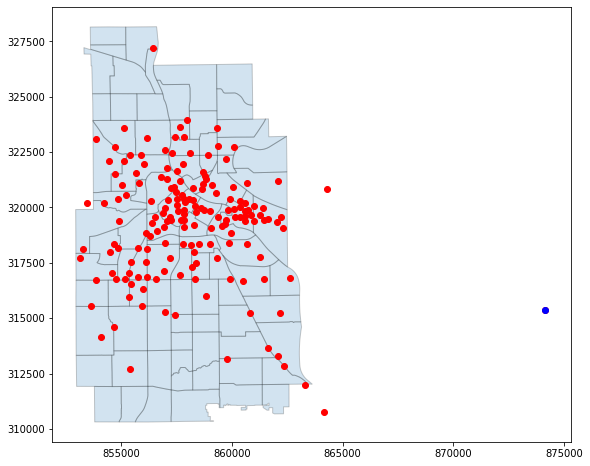

In [123]:
ax=mpls_geo.plot(figsize=(15,8), edgecolor='k', alpha=0.2)
gdf_stations.plot(ax=ax, color='red')
gdf_stations[gdf_stations['name']=='NRM Bike Shop 1'].plot(ax=ax, color='blue')

Is that a docking station in downtown St. Paul?

In [120]:
df_station[df_station['lon']==-93.06106567382812]

,name,lat,lon,id
164,NRM Bike Shop 1,44.934669,-93.061066,226.0


The NRM Bike Shop 1 station is the outlier. How many times does it appear in the dataset?

In [124]:
df[df['start station name']=='NRM Bike Shop 1']

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek,startday
12204,450,2019-08-05 10:38:37.622,2019-08-05 10:46:08.562,226.0,NRM Bike Shop 1,44.934669,-93.061066,62.0,Elliott Hall,44.976850,-93.238180,1353,Subscriber,1998,1,Classic,0.125000,0,0,Monday
27895,276,2019-08-12 12:10:12.043,2019-08-12 12:14:48.933,226.0,NRM Bike Shop 1,44.934669,-93.061066,211.0,15th Ave SE & SE 4th Street,44.979951,-93.234787,3500,Subscriber,1989,1,Classic,0.076667,0,0,Monday


In [125]:
df[df['end station name']=='NRM Bike Shop 1']

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek,startday
1117,436672,2019-08-01 14:41:34.019,2019-08-06 15:59:26.953,42.0,E Franklin Ave & Bloomington Ave S,44.962854,-93.252195,226.0,NRM Bike Shop 1,44.934669,-93.061066,518,Customer,1969,0,Classic,121.297778,3,1,Thursday
2602,904488,2019-08-02 00:14:22.680,2019-08-12 11:29:10.971,16.0,22nd Ave S & Franklin Ave,44.962930,-93.241042,226.0,NRM Bike Shop 1,44.934669,-93.061066,155,Customer,1969,0,Classic,251.246667,4,0,Friday
2603,315164,2019-08-02 00:14:36.927,2019-08-05 15:47:21.435,16.0,22nd Ave S & Franklin Ave,44.962930,-93.241042,226.0,NRM Bike Shop 1,44.934669,-93.061066,675,Customer,1969,0,Classic,87.545556,4,0,Friday
2667,383497,2019-08-02 03:21:14.679,2019-08-06 13:52:52.046,635.0,Hennepin Ave & S 3rd Street,44.980957,-93.270460,226.0,NRM Bike Shop 1,44.934669,-93.061066,1376,Customer,1969,0,Classic,106.526944,4,1,Friday
2670,906766,2019-08-02 03:22:51.428,2019-08-12 15:15:37.624,635.0,Hennepin Ave & S 3rd Street,44.980957,-93.270460,226.0,NRM Bike Shop 1,44.934669,-93.061066,347,Customer,1969,0,Classic,251.879444,4,0,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70112,1177999,2019-08-30 23:00:26.259,2019-09-13 14:13:45.400,93.0,Lake Calhoun Center,44.948467,-93.317294,226.0,NRM Bike Shop 1,44.934669,-93.061066,2062,Customer,1969,0,Classic,327.221944,4,4,Friday
70397,342,2019-08-31 09:06:13.251,2019-08-31 09:11:55.975,112.0,Como Ave SE & 29th Ave SE,44.987934,-93.212892,226.0,NRM Bike Shop 1,44.934669,-93.061066,3451,Subscriber,1966,2,Classic,0.095000,5,5,Saturday
71954,336940,2019-08-31 17:45:30.754,2019-09-04 15:21:11.707,184.0,S 5th Street & Nicollet Mall,44.978665,-93.270503,226.0,NRM Bike Shop 1,44.934669,-93.061066,559,Customer,1969,0,Classic,93.594444,5,2,Saturday
72575,399903,2019-08-31 22:54:21.496,2019-09-05 13:59:25.064,208.0,23rd Ave SE & University Ave SE,44.974397,-93.223002,226.0,NRM Bike Shop 1,44.934669,-93.061066,1116,Customer,1969,0,Classic,111.084167,5,3,Saturday


Note that many of the trips involved with NRM Bike Shop 1 are exceedingly long. I think it is safe to remove these trips from the dataset. I would guess that this is a repair shop of sorts.

## Dockless bikes
All NaNs in the start/end stations are the dockless bikes. The start/end precision is two decimal places in lat/lon. Best could do is heat map on lat/lon grid showing hot starting/ending times.

In [39]:
df.tail()

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,bike type,tripduration_hrs,startdayofweek,enddayofweek,startday,endday
72636,386,2019-08-31 23:47:15.121,2019-08-31 23:53:41.354,16.0,22nd Ave S & Franklin Ave,44.962930,-93.241042,41.0,Currie Park,44.969225,...,656,Customer,1969,0,Classic,0.107222,5,5,Saturday,Saturday
72637,745,2019-08-31 23:48:23.373,2019-09-01 00:00:48.397,34.0,Franklin & 11th Ave,44.962569,-93.258305,10.0,Midtown Exchange,44.948469,...,307,Subscriber,1977,2,Classic,0.206944,5,6,Saturday,Sunday
72638,1923,2019-08-31 23:55:30.188,2019-09-01 00:27:33.737,NaN,NaN,44.980000,-93.180000,NaN,NaN,44.980000,...,2532,Customer,1996,1,Dockless,0.534167,5,6,Saturday,Sunday
72639,480,2019-08-31 23:56:57.379,2019-09-01 00:04:57.473,NaN,NaN,44.970000,-93.230000,NaN,NaN,44.980000,...,2510,Customer,1977,2,Dockless,0.133333,5,6,Saturday,Sunday
72640,435,2019-08-31 23:57:37.373,2019-09-01 00:04:52.453,NaN,NaN,44.970000,-93.230000,NaN,NaN,44.980000,...,3129,Customer,1980,2,Dockless,0.120833,5,6,Saturday,Sunday


In [42]:
df_dockless=df[df['bike type']=='Dockless']
df_dockless.shape

(21441, 21)

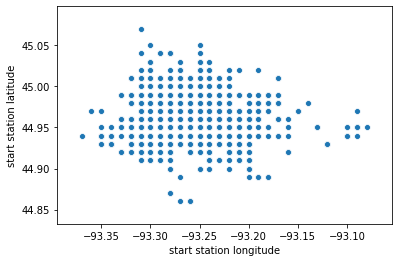

In [44]:
sns.scatterplot(x='start station longitude', y='start station latitude', data=df_dockless)

In [45]:
df_dockless['start station longitude'].value_counts()

-93.27    3581
-93.23    2806
-93.26    2738
-93.25    2354
-93.28    2206
-93.24    2179
-93.29    1638
-93.22     893
-93.31     868
-93.30     836
-93.21     700
-93.32     340
-93.18      92
-93.19      48
-93.33      38
-93.20      37
-93.17      36
-93.34      14
-93.35      10
-93.16       5
-93.09       5
-93.12       5
-93.10       4
-93.13       2
-93.15       2
-93.36       1
-93.14       1
-93.08       1
-93.37       1
Name: start station longitude, dtype: int64

In [48]:
set(df_dockless['start station longitude'])

{-93.37,
 -93.36,
 -93.35,
 -93.34,
 -93.33,
 -93.32,
 -93.31,
 -93.3,
 -93.29,
 -93.28,
 -93.27,
 -93.26,
 -93.25,
 -93.24,
 -93.23,
 -93.22,
 -93.21,
 -93.2,
 -93.19,
 -93.18,
 -93.17,
 -93.16,
 -93.15,
 -93.14,
 -93.13,
 -93.12,
 -93.1,
 -93.09,
 -93.08}

# Some other questions
- Is the mean travel time for subscribers vs customers the same?
- Is mean travel time for bike types the same?

In [131]:
# mean travel time
travel_time_cust = df[df['usertype']=='Customer']['tripduration'].mean()
travel_time_sub = df[df['usertype']=='Subscriber']['tripduration'].mean()

In [132]:
print('mean travel time for customers in hours is', travel_time_cust/60/60)
print('mean travel time for subscribers in hours is', travel_time_sub/60/60)

mean travel time for customers in hours is 2.899733223322332
mean travel time for subscribers in hours is 0.4821876956629848


This looks to be significantly different. Test the null hypothesis: The mean travel time between customers and subscribers is the same.

In [133]:
# mean travel time between Dockless and Classic
travel_time_classic = df[df['bike type']=='Classic']['tripduration'].mean()
travel_time_dockless = df[df['bike type']=='Dockless']['tripduration'].mean()
print('mean travel time for Classic bikes in hours is', travel_time_classic/60/60)
print('mean travel time for Dockless bikes in hours is', travel_time_dockless/60/60)

mean travel time for Classic bikes in hours is 1.7258839898003473
mean travel time for Dockless bikes in hours is 1.5209138903139883


These values are much closer. Test the null hypothesis: The mean travel time between Dockless and Classic bikes is the same.

## Mean travel times by start and end station

In [154]:
# Cut off long rides. Less than 2 hours.
df_short = df[df['tripduration']<=2*60*60]
df_short.shape

(70255, 20)

In [180]:
means=df_short[df_short['bike type']=='Classic'].groupby(['start station name'])['tripduration'].mean()

In [ ]:
df_short[df_short['bike type']=='Classic'].groupby(['start station name'])['tripduration'].mean()

In [184]:
means=means/60/60

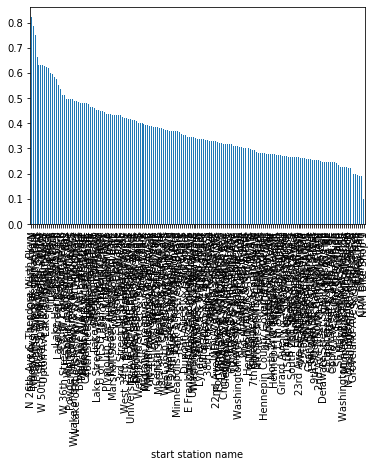

In [209]:
means.sort_values(ascending=False).plot(kind='bar')

In [198]:
means.sort_values(ascending=False)[:3].index

Index(['N 26th Ave & Theodore Wirth Pkwy', 'Elwood Ave N & Oak Park Ave N',
       'North Mississippi Regional Park'],
      dtype='object', name='start station name')

Text(0.5, 1, 'The stations with the longest mean trip duration')

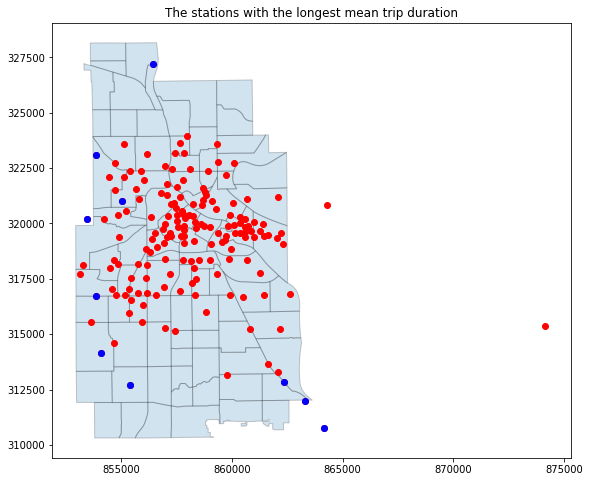

In [207]:
top_three=['N 26th Ave & Theodore Wirth Pkwy', 'Elwood Ave N & Oak Park Ave N',
       'North Mississippi Regional Park']
top_three=means.sort_values(ascending=False)[:10].index

ax=mpls_geo.plot(figsize=(15,8), edgecolor='k', alpha=0.2)
gdf_stations.plot(ax=ax, color='red')
for station in top_three:
    gdf_stations[gdf_stations['name']==station].plot(ax=ax, color='blue')
plt.title('The stations with the longest mean trip duration' )

We see the blue stations with the largest mean trip time are on the outskirts, along trails and bikeways.

Text(0.5, 1, 'The stations with the shortest mean trip duration')

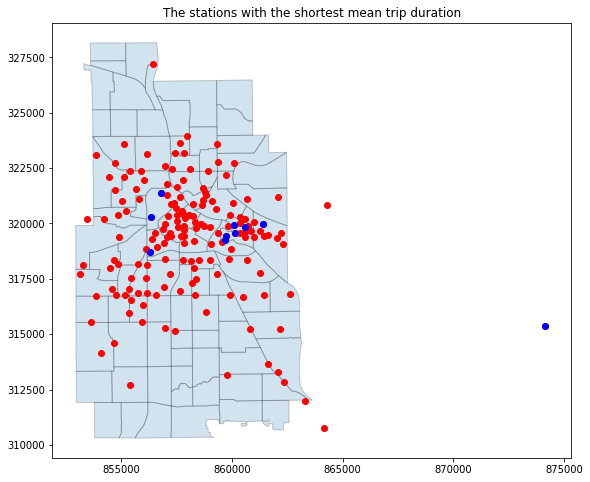

In [208]:

bottom_three=means.sort_values(ascending=True)[:10].index

ax=mpls_geo.plot(figsize=(15,8), edgecolor='k', alpha=0.2)
gdf_stations.plot(ax=ax, color='red')
for station in bottom_three:
    gdf_stations[gdf_stations['name']==station].plot(ax=ax, color='blue')
plt.title('The stations with the shortest mean trip duration' )